![Forecasting Demo 2: PyTorch Forecasting](https://raw.githubusercontent.com/VectorInstitute/forecasting-bootcamp/media-assets-do-not-merge/forecasting-demo-2.png?token=GHSAT0AAAAAABQMCWQFIGE34XPH3MQR2BBEYRHXQCQ)

[PyTorch Forecasting](https://github.com/jdb78/pytorch-forecasting) is a package/repository that provides convenient implementations of several leading deep learning-based forecasting models, namely [Temporal Fusion Transformers](https://arxiv.org/pdf/1912.09363.pdf), [N-BEATS](http://arxiv.org/abs/1905.10437), and [DeepAR](https://www.sciencedirect.com/science/article/pii/S0169207019301888). PyTorch Forecasting is built using [PyTorch Lightning](https://pytorch-lightning.readthedocs.io/), making it easier to train in multi-GPU compute environments, out-of-the-box. 

**Note for Colab users:** Run the following cell to install PyTorch Forecasting. After installation completes, you will likely need to restart the Colab runtime. If this is the case, a button `RESTART RUNTIME` will appear at the bottom of the next cell's output.

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install pytorch-forecasting

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, Callback
from pytorch_forecasting import TimeSeriesDataSet, NBeats, Baseline, DeepAR, GroupNormalizer, MultiNormalizer, EncoderNormalizer
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import MAPE, MAE, MASE, RMSE
from pytorch_forecasting.metrics import NormalDistributionLoss

In [3]:
class EpochCallback(Callback):
        
    def on_validation_epoch_end(self, trainer, module):
        print(trainer.progress_bar_metrics)

In [4]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

## Data Loading

We will continue with the same example dataset and task as the previous demo.

In [5]:
# data_filename = "/content/drive/MyDrive/bootcamp_datasets/boc_exchange/dataset.csv"
data_filename = "/ssd003/projects/forecasting_bootcamp/bootcamp_datasets/cpi_forecasting/all_data.csv"
data_df = pd.read_csv(data_filename, index_col=0)
data_df.index = pd.to_datetime(data_df.index)
data_df = data_df.reset_index().rename({'index':'date'}, axis=1)
data_df

,date,Bakery and cereal products (excluding baby food),Dairy products and eggs,"Fish, seafood and other marine products",Food purchased from restaurants,Food,"Fruit, fruit preparations and nuts",Meat,Other food products and non-alcoholic beverages,Vegetables and vegetable preparations,...,XTIMVA01CAM657S,XTIMVA01CAM659S,XTIMVA01CAM664N,XTIMVA01CAM664S,XTIMVA01CAM667S,XTNTVA01CAM664N,XTNTVA01CAM664S,XTNTVA01CAM667S,TOTALNS,TOTALSL
0,1986-01-01,69.3,70.9,60.6,59.1,67.3,76.0,65.1,77.5,76.0,...,3.644028,12.050836,9.368000e+09,9.496200e+09,6.748621e+09,6.906000e+08,1.052400e+09,7.479043e+08,607.36898,605.70302
1,1986-02-01,70.3,70.8,61.3,59.1,66.9,77.6,64.2,78.1,68.4,...,1.964888,16.745358,9.495000e+09,9.632200e+09,6.881224e+09,-9.880000e+07,1.539000e+08,1.099459e+08,605.80702,610.67829
2,1986-03-01,70.6,71.1,61.3,59.3,67.0,79.2,64.2,78.6,66.2,...,-11.565073,1.654991,8.802600e+09,8.528600e+09,6.085406e+09,9.138000e+08,9.079000e+08,6.478132e+08,606.79900,613.37662
3,1986-04-01,71.3,71.0,61.4,59.7,67.7,82.2,63.6,79.5,71.1,...,13.334090,10.821208,1.034410e+10,9.568800e+09,6.896839e+09,3.470000e+08,6.563000e+08,4.730369e+08,614.36685,619.65773
4,1986-05-01,71.2,71.4,61.9,59.9,68.2,83.5,64.0,79.8,75.3,...,-4.235546,6.159794,9.597500e+09,9.090800e+09,6.604720e+09,7.013000e+08,6.893000e+08,5.007957e+08,621.91515,625.81996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,2021-06-01,157.7,145.3,146.2,163.9,156.8,144.5,176.7,142.2,153.4,...,-1.087481,31.560803,5.159130e+10,4.979400e+10,4.075250e+10,3.661000e+09,3.110700e+09,2.545865e+09,4259.60393,4307.13715
426,2021-07-01,157.9,146.4,146.6,165.2,157.6,141.7,180.9,141.9,154.8,...,1.989962,18.580278,5.105560e+10,5.204860e+10,4.156346e+10,3.780000e+08,1.129300e+09,9.018036e+08,4276.20187,4323.73021
427,2021-08-01,158.5,148.3,146.8,165.9,158.0,142.5,182.1,141.7,152.2,...,-2.312122,14.722502,5.244520e+10,5.114600e+10,4.060246e+10,1.300500e+09,2.673900e+09,2.122687e+09,4316.30272,4337.48931
428,2021-09-01,158.1,148.0,147.1,165.9,158.5,141.5,184.8,144.3,150.0,...,-3.460786,8.557485,5.079560e+10,4.965300e+10,3.919730e+10,1.560600e+09,2.277300e+09,1.797757e+09,4346.66210,4367.40241


In [6]:
food_categories = data_df.columns[1:10]
food_categories

Index(['Bakery and cereal products (excluding baby food)',
       'Dairy products and eggs', 'Fish, seafood and other marine products',
       'Food purchased from restaurants', 'Food',
       'Fruit, fruit preparations and nuts', 'Meat',
       'Other food products and non-alcoholic beverages',
       'Vegetables and vegetable preparations'],
      dtype='object')

In [7]:
# data_df = data_df[['date'] + food_categories.tolist()]

## Data Splitting

We immediately split the data into training and test sets. We can later split the training set into training and validation.

In [8]:
train_size = 0.8

train_df = data_df.iloc[:int(len(data_df)*train_size)]
test_df = data_df.iloc[int(len(data_df)*train_size):]

## Data Formatting

PyTorch Forecasting expects data to be formatted using its own [TimeSeriesDataSet](https://pytorch-forecasting.readthedocs.io/en/latest/data.html) objects. Building a TimeSeriesDataSet begins with a Pandas DataFrame, and like with Prophet and NeuralProphet, we need to add certain custom columns.

For this demo, we are once again specifying a lead time of 30 days and we will withhold the last 20% of data for testing. In the code below, we are very careful to ensure that when training and validating the model, it does not have access to the withheld data.

## Time Series Data Formatting

PyTorch Forecasting models can accomodate datasets consisting of multiple, coincident time series in several ways. As per the [documentation](https://pytorch-forecasting.readthedocs.io/en/latest/data.html), a combination of `group_id` and `time_idx` identify a sample in the data, and that *if we have only one time series, to set* `group_id` *to a constant.*

`time_idx` is an *integer column denoting the time index*. This, as opposed to the `date` column, is used to determine the temporal sequence of samples. 

In [9]:
lag_time = 5*12
lead_time = 12
train_df = train_df.reset_index().rename({'index':'time_idx'}, axis=1)
test_df = test_df.reset_index().rename({'index':'time_idx'}, axis=1)

train_df['group_ids'] = 0
test_df['group_ids'] = 0

In [10]:
train_df

,time_idx,date,Bakery and cereal products (excluding baby food),Dairy products and eggs,"Fish, seafood and other marine products",Food purchased from restaurants,Food,"Fruit, fruit preparations and nuts",Meat,Other food products and non-alcoholic beverages,...,XTIMVA01CAM659S,XTIMVA01CAM664N,XTIMVA01CAM664S,XTIMVA01CAM667S,XTNTVA01CAM664N,XTNTVA01CAM664S,XTNTVA01CAM667S,TOTALNS,TOTALSL,group_ids
0,0,1986-01-01,69.3,70.9,60.6,59.1,67.3,76.0,65.1,77.5,...,12.050836,9.368000e+09,9.496200e+09,6.748621e+09,6.906000e+08,1.052400e+09,7.479043e+08,607.36898,605.70302,0
1,1,1986-02-01,70.3,70.8,61.3,59.1,66.9,77.6,64.2,78.1,...,16.745358,9.495000e+09,9.632200e+09,6.881224e+09,-9.880000e+07,1.539000e+08,1.099459e+08,605.80702,610.67829,0
2,2,1986-03-01,70.6,71.1,61.3,59.3,67.0,79.2,64.2,78.6,...,1.654991,8.802600e+09,8.528600e+09,6.085406e+09,9.138000e+08,9.079000e+08,6.478132e+08,606.79900,613.37662,0
3,3,1986-04-01,71.3,71.0,61.4,59.7,67.7,82.2,63.6,79.5,...,10.821208,1.034410e+10,9.568800e+09,6.896839e+09,3.470000e+08,6.563000e+08,4.730369e+08,614.36685,619.65773,0
4,4,1986-05-01,71.2,71.4,61.9,59.9,68.2,83.5,64.0,79.8,...,6.159794,9.597500e+09,9.090800e+09,6.604720e+09,7.013000e+08,6.893000e+08,5.007957e+08,621.91515,625.81996,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,339,2014-04-01,151.0,135.6,121.5,134.5,134.6,125.9,140.5,129.8,...,0.054110,4.355280e+10,4.255990e+10,3.872170e+10,-6.580000e+08,9.428000e+08,8.577750e+08,3122.74567,3168.27326,0
340,340,2014-05-01,150.8,135.0,124.0,134.6,135.7,128.3,145.2,130.1,...,5.858256,4.454330e+10,4.361940e+10,4.006525e+10,6.175000e+08,1.477900e+09,1.357479e+09,3145.32759,3186.24512,0
341,341,2014-06-01,152.0,134.9,125.8,135.1,136.4,128.1,147.4,129.2,...,2.753318,4.372570e+10,4.253300e+10,3.928852e+10,1.461100e+09,1.822400e+09,1.683385e+09,3164.01030,3204.14270,0
342,342,2014-07-01,151.9,135.2,126.1,135.3,136.5,128.4,147.7,129.7,...,4.389801,4.197800e+10,4.224030e+10,3.933960e+10,1.491300e+09,2.430000e+09,2.263129e+09,3184.82314,3226.22583,0


## Preparing a TimeSeriesDataSet for N-BEATS

N-BEATS is a univariate forecasting method. As such, it can only process one variable at a time.

In [11]:
train_df_nbeats = train_df.melt(id_vars=['time_idx', 'date'], value_vars=data_df.columns, var_name='group_ids')
train_df_nbeats.head()

,time_idx,date,group_ids,value
0,0,1986-01-01,Bakery and cereal products (excluding baby food),69.3
1,1,1986-02-01,Bakery and cereal products (excluding baby food),70.3
2,2,1986-03-01,Bakery and cereal products (excluding baby food),70.6
3,3,1986-04-01,Bakery and cereal products (excluding baby food),71.3
4,4,1986-05-01,Bakery and cereal products (excluding baby food),71.2


In [12]:
train_df_nbeats.tail()

,time_idx,date,group_ids,value
114203,339,2014-04-01,TOTALSL,3168.27326
114204,340,2014-05-01,TOTALSL,3186.24512
114205,341,2014-06-01,TOTALSL,3204.14270
114206,342,2014-07-01,TOTALSL,3226.22583
114207,343,2014-08-01,TOTALSL,3242.36063


The following code defines the training/validation split and important parts of the prediction task - the lag time and lead time. Here we are specifying that 25% of the training data should be used for validation. In total, this results in a 60/20/20 train/valid/test split (since 25% of 80% is 20% of the initial 100%).

In [13]:
# define dataset
valid_size = 0.25  
max_encoder_length = lag_time
max_prediction_length = lead_time
training_cutoff = train_df_nbeats["time_idx"][:int((1 - valid_size)*train_df_nbeats["time_idx"].max())].values[-1]
context_length = max_encoder_length
prediction_length = max_prediction_length

Since NBEATS is actually a univariate forecasting model, it makes sense that pytorch-forecasting does not support specifying explanatory variables as `time_varying_unknown_reals`. Earlier, we used the Pandas function `melt` to reshape the data into a single `value` column that is uniquely indexed by pairs of `(time_idx, group_ids)`.

In [15]:
training = TimeSeriesDataSet(
    train_df_nbeats.loc[train_df_nbeats.time_idx <= training_cutoff],  # Applying the training cutoff
    time_idx="time_idx",
    target="value",
    categorical_encoders={"group_ids": NaNLabelEncoder().fit(train_df_nbeats.group_ids)},
    group_ids=['group_ids'],
    max_encoder_length=context_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=["value"],
)

In [16]:
validation = TimeSeriesDataSet.from_dataset(training, train_df_nbeats, min_prediction_idx=training_cutoff + 1)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

## Training the model

In our first effort to train the N-BEATS model, we adopt the default configuration suggested by the pytorch-forecasting [tutorials](https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/ar.html).

In [17]:
pl.seed_everything(42)
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
epoch_callback = EpochCallback()

trainer = pl.Trainer(
    max_epochs=50,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.01,
    callbacks=[early_stop_callback, epoch_callback],
    limit_train_batches=1.0,
)

net = NBeats.from_dataset(
    training,
    learning_rate=1e-4,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    # widths=[16, 16],
    # backcast_loss_ratio=1.0,
)

trainer.fit(
    net,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/models/nbeats/sub_modules.py:154: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  coefficients = torch.tensor([backcast_linspace ** i for i in range(thetas_dim)], dtype=torch.float32)
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:735: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM han

Validation sanity check: 0it [00:00, ?it/s]

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 128. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
Global seed set to 42


{'sanity_check_loss': 7.789648056030273}


/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with highe

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Validating: 0it [00:00, ?it/s]

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


{'train_loss_step': 2.637212038040161, 'val_loss': 3.823648452758789}


/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with highe

Validating: 0it [00:00, ?it/s]

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


{'train_loss_step': 2.74075984954834, 'val_loss': 3.2392308712005615, 'train_loss_epoch': 5.062295436859131}


/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with highe

Validating: 0it [00:00, ?it/s]

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


{'train_loss_step': 2.677812337875366, 'val_loss': 3.089556932449341, 'train_loss_epoch': 2.8468518257141113}


/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with highe

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Validating: 0it [00:00, ?it/s]

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


{'train_loss_step': 2.4442138671875, 'val_loss': 3.0732834339141846, 'train_loss_epoch': 2.6087939739227295}


/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with highe

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with highe

Validating: 0it [00:00, ?it/s]

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


{'train_loss_step': 2.188148260116577, 'val_loss': 3.0363290309906006, 'train_loss_epoch': 2.508289337158203}


/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with highe

Validating: 0it [00:00, ?it/s]

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


{'train_loss_step': 2.1841084957122803, 'val_loss': 3.030474901199341, 'train_loss_epoch': 2.4399702548980713}


/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with highe

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Validating: 0it [00:00, ?it/s]

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


{'train_loss_step': 2.374108076095581, 'val_loss': 2.9674904346466064, 'train_loss_epoch': 2.400968313217163}


/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with highe

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Validating: 0it [00:00, ?it/s]

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


{'train_loss_step': 2.3347816467285156, 'val_loss': 2.988778591156006, 'train_loss_epoch': 2.36421799659729}


/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with highe

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Validating: 0it [00:00, ?it/s]

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


{'train_loss_step': 2.3889811038970947, 'val_loss': 2.999532699584961, 'train_loss_epoch': 2.3387160301208496}


/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with highe

Validating: 0it [00:00, ?it/s]

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


{'train_loss_step': 2.118800163269043, 'val_loss': 2.975623369216919, 'train_loss_epoch': 2.3073558807373047}


/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with highe

Validating: 0it [00:00, ?it/s]

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


{'train_loss_step': 2.1812002658843994, 'val_loss': 2.9801650047302246, 'train_loss_epoch': 2.2832393646240234}


/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with highe

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Validating: 0it [00:00, ?it/s]

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


{'train_loss_step': 2.256937265396118, 'val_loss': 3.015209674835205, 'train_loss_epoch': 2.2582015991210938}


/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with highe

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with highe

Validating: 0it [00:00, ?it/s]

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


{'train_loss_step': 2.4875009059906006, 'val_loss': 2.999213218688965, 'train_loss_epoch': 2.2450454235076904}


/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with highe

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with highe

Validating: 0it [00:00, ?it/s]

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


{'train_loss_step': 2.2879111766815186, 'val_loss': 3.0272815227508545, 'train_loss_epoch': 2.223353862762451}


/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with highe

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Validating: 0it [00:00, ?it/s]

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


{'train_loss_step': 2.175075054168701, 'val_loss': 3.006117820739746, 'train_loss_epoch': 2.2102856636047363}


/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with highe

Validating: 0it [00:00, ?it/s]

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


{'train_loss_step': 2.3751442432403564, 'val_loss': 3.0253396034240723, 'train_loss_epoch': 2.192707061767578}


/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with highe

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Validating: 0it [00:00, ?it/s]

/ssd003/projects/aieng/public/forecasting_unified/lib/python3.8/site-packages/pytorch_forecasting/data/encoders.py:373: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


{'train_loss_step': 2.332914113998413, 'val_loss': 3.0345146656036377, 'train_loss_epoch': 2.181081533432007}


## Testing the model


In [18]:
test_dataset = TimeSeriesDataSet(
    test_df,
    time_idx="time_idx",
    target="Fruit, fruit preparations and nuts",
    group_ids=['group_ids'],
    max_encoder_length=context_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=["Fruit, fruit preparations and nuts"],
)

test_dataloader = test_dataset.to_dataloader(train=False, batch_size=1, num_workers=0)

In [19]:
len(test_dataset)

15

## Collect test set predictions

In [20]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)
print(best_model_path)

actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
predictions = best_model.predict(test_dataloader)

/scratch/ssd001/home/ethanj/forecasting-bootcamp/demos/lightning_logs/version_6613709/checkpoints/epoch=16-step=8193.ckpt


## Plot model forecasts at max lead time

Like in Demo 1, we are plotting the predictions at max lead time as well as one individual example forecast. Feel free to modify the `start` variable to plot different examples.

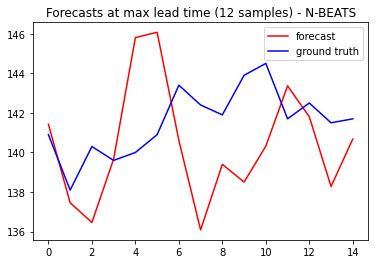

In [21]:
actuals_np = actuals.detach().numpy()
predictions_np = predictions.detach().numpy()

indexes = []
preds = []
trues = []

for time_idx in range(actuals_np.shape[0]):
    indexes.append(time_idx)
    preds.append(predictions_np[time_idx][-1])
    trues.append(actuals_np[time_idx][-1])

fig, ax = plt.subplots()
ax.plot(indexes, preds, color='red', label='forecast')
ax.plot(indexes, trues, color='blue', label='ground truth')
ax.set_title(f"Forecasts at max lead time ({lead_time} samples) - N-BEATS")
ax.legend()

In [22]:
actuals_np.shape

(15, 12)

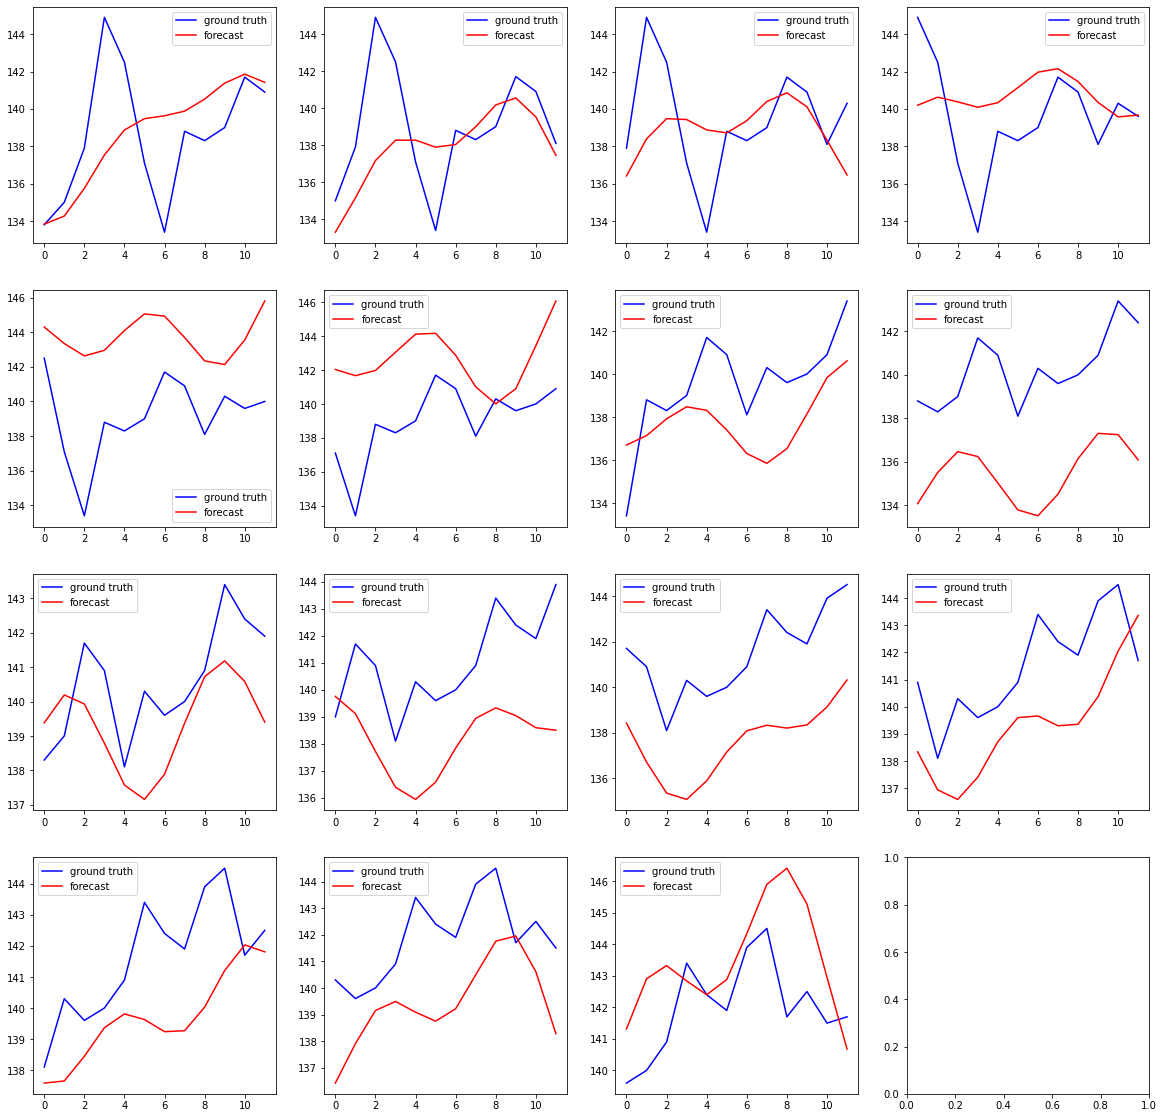

In [23]:
# plot at single time index

fig, axs = plt.subplots(4, 4, figsize=(20,20))
axs = axs.flatten()

for fig_index, example_index in enumerate(range(0, len(predictions_np), 1)):

    if fig_index > len(axs) - 1:
        break

    ground_truth = actuals_np[example_index]
    forecast = predictions_np[example_index]

    axs[fig_index].plot(list(range(0, len(forecast))), ground_truth, color='blue', label='ground truth')
    axs[fig_index].plot(list(range(0, len(forecast))), forecast, color='red', label='forecast')
    axs[fig_index].legend()

## Standard evaluation metrics


In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

metrics = {
    'mse': mean_squared_error,
    'rmse': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    'mae': mean_absolute_error,
    'mape': mean_absolute_percentage_error
}

def compute_error_statistics(error_metrics_dict, exp_name):
    return {
        'mean': pd.DataFrame(error_metrics_dict).mean(axis=0).rename(f'{exp_name}_mean_metrics'),
        'std': pd.DataFrame(error_metrics_dict).std(axis=0).rename(f'{exp_name}_std_metrics'),
        'max': pd.DataFrame(error_metrics_dict).max(axis=0).rename(f'{exp_name}_max_metrics'),
    }

def compute_baseline_error_metrics(predictions, actuals):

    errors = {metric_name:[] for metric_name in metrics.keys()}

    for i in range(len(predictions)):
    
        for metric_name, metric_fn in metrics.items(): 
                errors[metric_name].append(metric_fn(y_true=actuals[i], y_pred=predictions[i]))

    return errors

In [25]:
actuals_np = actuals.detach().numpy()
predictions_np = predictions.detach().numpy()

nbeats_errors = compute_baseline_error_metrics(predictions_np, actuals_np)
nbeats_stats = compute_error_statistics(nbeats_errors, 'nbeats')
nbeats_stats['mean']

mse     11.112105
rmse     3.202046
mae      2.781155
mape     0.019834
Name: nbeats_mean_metrics, dtype: float32